In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("flight_delay_predict.csv")

# Quick look
print(df.shape)
df.head()


(3000000, 32)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [2]:
# Missing values per column
print(df.isna().sum())

# Column data types
print(df.dtypes)

# Basic info
df.info()


FL_DATE                          0
AIRLINE                          0
AIRLINE_DOT                      0
AIRLINE_CODE                     0
DOT_CODE                         0
FL_NUMBER                        0
ORIGIN                           0
ORIGIN_CITY                      0
DEST                             0
DEST_CITY                        0
CRS_DEP_TIME                     0
DEP_TIME                     77615
DEP_DELAY                    77644
TAXI_OUT                     78806
WHEELS_OFF                   78806
WHEELS_ON                    79944
TAXI_IN                      79944
CRS_ARR_TIME                     0
ARR_TIME                     79942
ARR_DELAY                    86198
CANCELLED                        0
CANCELLATION_CODE          2920860
DIVERTED                         0
CRS_ELAPSED_TIME                14
ELAPSED_TIME                 86198
AIR_TIME                     86198
DISTANCE                         0
DELAY_DUE_CARRIER          2466137
DELAY_DUE_WEATHER   

In [3]:
# Quick check
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  CANCELLA

FL_DATE                          0
AIRLINE                          0
AIRLINE_DOT                      0
AIRLINE_CODE                     0
DOT_CODE                         0
FL_NUMBER                        0
ORIGIN                           0
ORIGIN_CITY                      0
DEST                             0
DEST_CITY                        0
CRS_DEP_TIME                     0
DEP_TIME                     77615
DEP_DELAY                    77644
TAXI_OUT                     78806
WHEELS_OFF                   78806
WHEELS_ON                    79944
TAXI_IN                      79944
CRS_ARR_TIME                     0
ARR_TIME                     79942
ARR_DELAY                    86198
CANCELLED                        0
CANCELLATION_CODE          2920860
DIVERTED                         0
CRS_ELAPSED_TIME                14
ELAPSED_TIME                 86198
AIR_TIME                     86198
DISTANCE                         0
DELAY_DUE_CARRIER          2466137
DELAY_DUE_WEATHER   

In [4]:
# Create binary target column: 1 if ARR_DELAY > 15 mins, else 0
df["DELAYED"] = (df["ARR_DELAY"] > 15).astype(int)


In [5]:
# Keep only relevant columns
df_clean = df[[
    "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DEP_DELAY", "ARR_DELAY",
    "CANCELLED", "DIVERTED", "DELAYED"
]].copy()


In [6]:
df_clean["DEP_DELAY"] = df_clean["DEP_DELAY"].fillna(0)
df_clean["ARR_DELAY"] = df_clean["ARR_DELAY"].fillna(0)


In [7]:
import sqlite3
# Create SQLite in-memory database
conn = sqlite3.connect(":memory:")

# Write DataFrame to SQLite table
df_clean.to_sql("flights", conn, index=False, if_exists="replace")
columns = conn.execute("PRAGMA table_info(flights);").fetchall()
for col in columns:
    print(col[1])
query = """
SELECT 
    "AIRLINE",
    "ORIGIN",
    "DEST",
    AVG("DEP_DELAY") AS avg_dep_delay,
    SUM(CASE WHEN "DEP_DELAY" > 15 THEN 1 ELSE 0 END) AS delayed_flights,
    COUNT(*) AS total_flights
FROM flights
GROUP BY "AIRLINE", "ORIGIN", "DEST"
ORDER BY total_flights DESC
LIMIT 3000000;
"""

df_agg = pd.read_sql_query(query, conn)
df_agg


FL_DATE
AIRLINE
ORIGIN
DEST
DEP_DELAY
ARR_DELAY
CANCELLED
DIVERTED
DELAYED


,AIRLINE,ORIGIN,DEST,avg_dep_delay,delayed_flights,total_flights
0,Hawaiian Airlines Inc.,OGG,HNL,3.918088,523,3577
1,Hawaiian Airlines Inc.,HNL,OGG,2.863558,344,3496
2,Alaska Airlines Inc.,SEA,ANC,7.100243,473,2474
3,Hawaiian Airlines Inc.,HNL,KOA,1.836238,240,2467
4,Hawaiian Airlines Inc.,LIH,HNL,1.542497,266,2459
...,...,...,...,...,...,...
17814,United Air Lines Inc.,SJC,LAS,30.000000,1,1
17815,United Air Lines Inc.,SMF,LAX,-13.000000,0,1
17816,United Air Lines Inc.,SRQ,IAH,12.000000,0,1
17817,United Air Lines Inc.,TVC,EWR,-2.000000,0,1


In [8]:
df_agg.sort_values('delayed_flights', ascending=False).head(3000000)


,AIRLINE,ORIGIN,DEST,avg_dep_delay,delayed_flights,total_flights
0,Hawaiian Airlines Inc.,OGG,HNL,3.918088,523,3577
29,Southwest Airlines Co.,DEN,PHX,13.846756,496,1788
13,American Airlines Inc.,DFW,LAX,15.255136,484,2093
2,Alaska Airlines Inc.,SEA,ANC,7.100243,473,2474
9,Delta Air Lines Inc.,ATL,MCO,11.143408,446,2336
...,...,...,...,...,...,...
17802,United Air Lines Inc.,RDU,SBN,-8.000000,0,1
17801,United Air Lines Inc.,PHX,PHL,-9.000000,0,1
17799,United Air Lines Inc.,ORD,SBN,10.000000,0,1
17798,United Air Lines Inc.,ORD,GRB,-10.000000,0,1


In [9]:
df_agg.sort_values('avg_dep_delay', ascending=False).head(3000000)


,AIRLINE,ORIGIN,DEST,avg_dep_delay,delayed_flights,total_flights
17180,Allegiant Air,DEN,ABE,1089.000000,1,1
17465,Frontier Airlines Inc.,RDU,EWR,888.000000,1,1
17575,Republic Airline,MIA,HSV,681.000000,1,1
17724,Southwest Airlines Co.,MIA,PIT,445.000000,1,1
16071,American Airlines Inc.,FCA,LGA,394.500000,2,4
...,...,...,...,...,...,...
17224,American Airlines Inc.,GSP,ORD,-23.000000,0,1
17173,Allegiant Air,BNA,GFK,-24.000000,0,1
17126,Spirit Air Lines,PBG,IAG,-28.500000,0,2
13921,Alaska Airlines Inc.,PIT,BWI,-28.538462,0,13


In [10]:
df_agg['perc_delayed'] = (df_agg['delayed_flights'] / df_agg['total_flights']) * 100
df_agg.sort_values('perc_delayed', ascending=False).head(3000000)


,AIRLINE,ORIGIN,DEST,avg_dep_delay,delayed_flights,total_flights,perc_delayed
17776,United Air Lines Inc.,FLL,LAS,389.000000,1,1,100.0
17810,United Air Lines Inc.,SDF,SFO,28.000000,1,1,100.0
17800,United Air Lines Inc.,ORD,XNA,87.000000,1,1,100.0
17814,United Air Lines Inc.,SJC,LAS,30.000000,1,1,100.0
17788,United Air Lines Inc.,LAS,SMF,31.000000,1,1,100.0
...,...,...,...,...,...,...,...
17777,United Air Lines Inc.,GSP,IAD,-4.000000,0,1,0.0
17778,United Air Lines Inc.,GUC,IAH,-4.000000,0,1,0.0
13944,Allegiant Air,SFB,OGS,-2.000000,0,13,0.0
13961,American Airlines Inc.,LAX,SMF,-1.769231,0,13,0.0


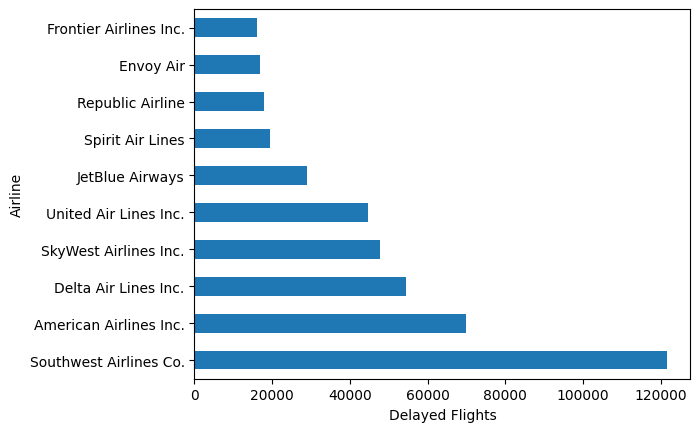

In [11]:
import matplotlib.pyplot as plt
df_agg.groupby('AIRLINE')['delayed_flights'].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel("Delayed Flights")
plt.ylabel("Airline")
plt.show()


In [12]:
df_agg.to_csv("flights_aggregated.csv", index=False)


In [13]:
# Step 1: Percentage of Delayed Flights per Route 
#Calculate percentage of delayed flights per route
df_agg['perc_delayed'] = (df_agg['delayed_flights'] / df_agg['total_flights']) * 100

# Top 20 routes by percentage of delayed flights
top_delayed_routes = df_agg.sort_values('perc_delayed', ascending=False).head(3000000)
top_delayed_routes


,AIRLINE,ORIGIN,DEST,avg_dep_delay,delayed_flights,total_flights,perc_delayed
17776,United Air Lines Inc.,FLL,LAS,389.000000,1,1,100.0
17810,United Air Lines Inc.,SDF,SFO,28.000000,1,1,100.0
17800,United Air Lines Inc.,ORD,XNA,87.000000,1,1,100.0
17814,United Air Lines Inc.,SJC,LAS,30.000000,1,1,100.0
17788,United Air Lines Inc.,LAS,SMF,31.000000,1,1,100.0
...,...,...,...,...,...,...,...
17777,United Air Lines Inc.,GSP,IAD,-4.000000,0,1,0.0
17778,United Air Lines Inc.,GUC,IAH,-4.000000,0,1,0.0
13944,Allegiant Air,SFB,OGS,-2.000000,0,13,0.0
13961,American Airlines Inc.,LAX,SMF,-1.769231,0,13,0.0


In [14]:
#Step 2: Top Airlines by Total Delayed Flights
# Total delayed flights per airline
airline_delays = df_agg.groupby('AIRLINE')['delayed_flights'].sum().sort_values(ascending=False)

# Display top 10 airlines with most delayed flights
airline_delays.head(3000000)



AIRLINE
Southwest Airlines Co.                121544
American Airlines Inc.                 69878
Delta Air Lines Inc.                   54344
SkyWest Airlines Inc.                  47668
United Air Lines Inc.                  44771
JetBlue Airways                        28958
Spirit Air Lines                       19536
Republic Airline                       17953
Envoy Air                              16905
Frontier Airlines Inc.                 16219
PSA Airlines Inc.                      15891
Alaska Airlines Inc.                   15119
Endeavor Air Inc.                      12868
Allegiant Air                          11550
Mesa Airlines Inc.                     10617
Hawaiian Airlines Inc.                  4281
ExpressJet Airlines LLC d/b/a aha!      3218
Horizon Air                             2499
Name: delayed_flights, dtype: int64

In [15]:
#Step 3: Top Airlines by Average Delay
# Weighted average delay per airline
airline_avg_delay = df_agg.groupby('AIRLINE').apply(
    lambda x: (x['avg_dep_delay'] * x['total_flights']).sum() / x['total_flights'].sum()
).sort_values(ascending=False)

airline_avg_delay.head(3000000)
#Step 4: Top Routes by Average Delay
# Top 20 routes with highest average departure delay
top_avg_delay_routes = df_agg.sort_values('avg_dep_delay', ascending=False).head(20)
top_avg_delay_routes



C:\Users\user\AppData\Local\Temp\ipykernel_7856\757296620.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  airline_avg_delay = df_agg.groupby('AIRLINE').apply(


,AIRLINE,ORIGIN,DEST,avg_dep_delay,delayed_flights,total_flights,perc_delayed
17180,Allegiant Air,DEN,ABE,1089.000000,1,1,100.000000
17465,Frontier Airlines Inc.,RDU,EWR,888.000000,1,1,100.000000
17575,Republic Airline,MIA,HSV,681.000000,1,1,100.000000
17724,Southwest Airlines Co.,MIA,PIT,445.000000,1,1,100.000000
16071,American Airlines Inc.,FCA,LGA,394.500000,2,4,50.000000
17572,Republic Airline,MCO,PIT,390.000000,1,1,100.000000
17776,United Air Lines Inc.,FLL,LAS,389.000000,1,1,100.000000
16458,ExpressJet Airlines LLC d/b/a aha!,IAD,LEX,373.000000,1,3,33.333333
16791,Endeavor Air Inc.,ATL,FAR,357.500000,1,2,50.000000
15514,Allegiant Air,SFB,GFK,297.333333,2,6,33.333333


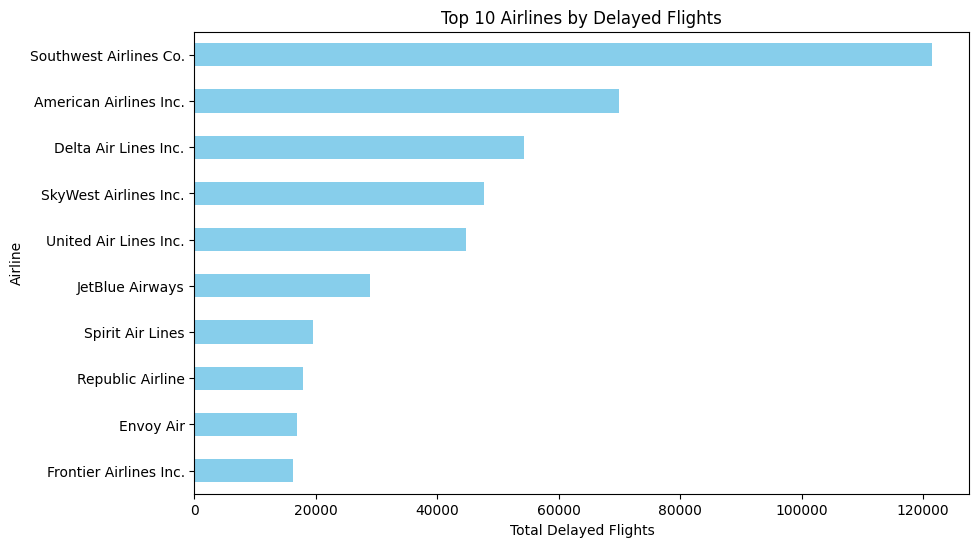

In [16]:
import matplotlib.pyplot as plt

airline_delays.head(10).plot(kind='barh', figsize=(10,6), color='skyblue')
plt.xlabel("Total Delayed Flights")
plt.ylabel("Airline")
plt.title("Top 10 Airlines by Delayed Flights")
plt.gca().invert_yaxis()  # highest at top
plt.show()


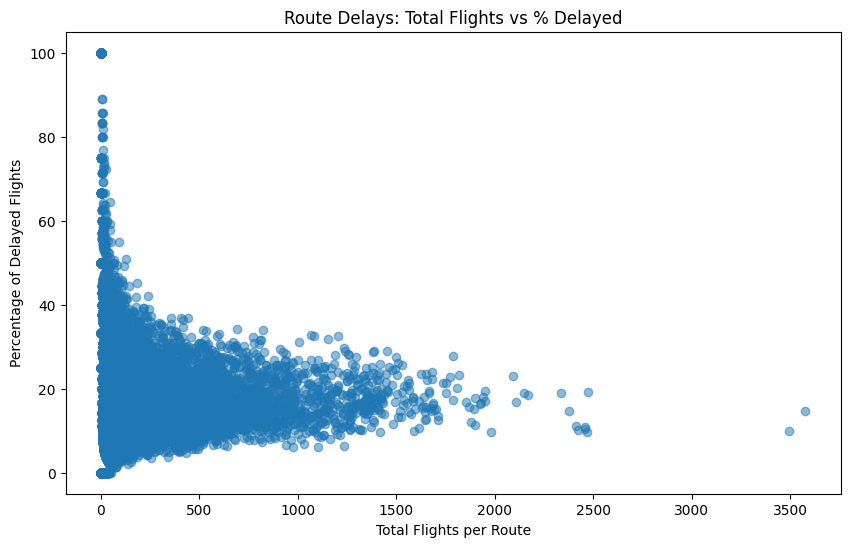

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(df_agg['total_flights'], df_agg['perc_delayed'], alpha=0.5)
plt.xlabel("Total Flights per Route")
plt.ylabel("Percentage of Delayed Flights")
plt.title("Route Delays: Total Flights vs % Delayed")
plt.show()


In [18]:
df_agg.to_csv("flights_aggregated_analysis.csv", index=False)


In [19]:
print(df_clean.columns.tolist())


['FL_DATE', 'AIRLINE', 'ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'DELAYED']


In [20]:
features = ['DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'AIRLINE']
X = df_clean[features]
y = df_clean['DELAYED']


In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['ORIGIN', 'DEST', 'AIRLINE']
numeric_features = ['DEP_DELAY', 'ARR_DELAY']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)


In [22]:
X_encoded = preprocessor.fit_transform(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    496942
           1       1.00      1.00      1.00    103058

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000

